#Introduction

This is one of our firsts notebook, which gave us a starting point on which reason. We put two bidirectional LSTMs in this notebook. We started before with windoe 250 and patience 30, and we tuned parameters, until we reached a reasonable result. With this notebook, where the window is set to 90, and the stride is set to 5 (and by considering an autoregressive approach), we reached a score of approximately 5.28.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


# Import libraries

In [ ]:
title = 'Patience30Win90st5' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


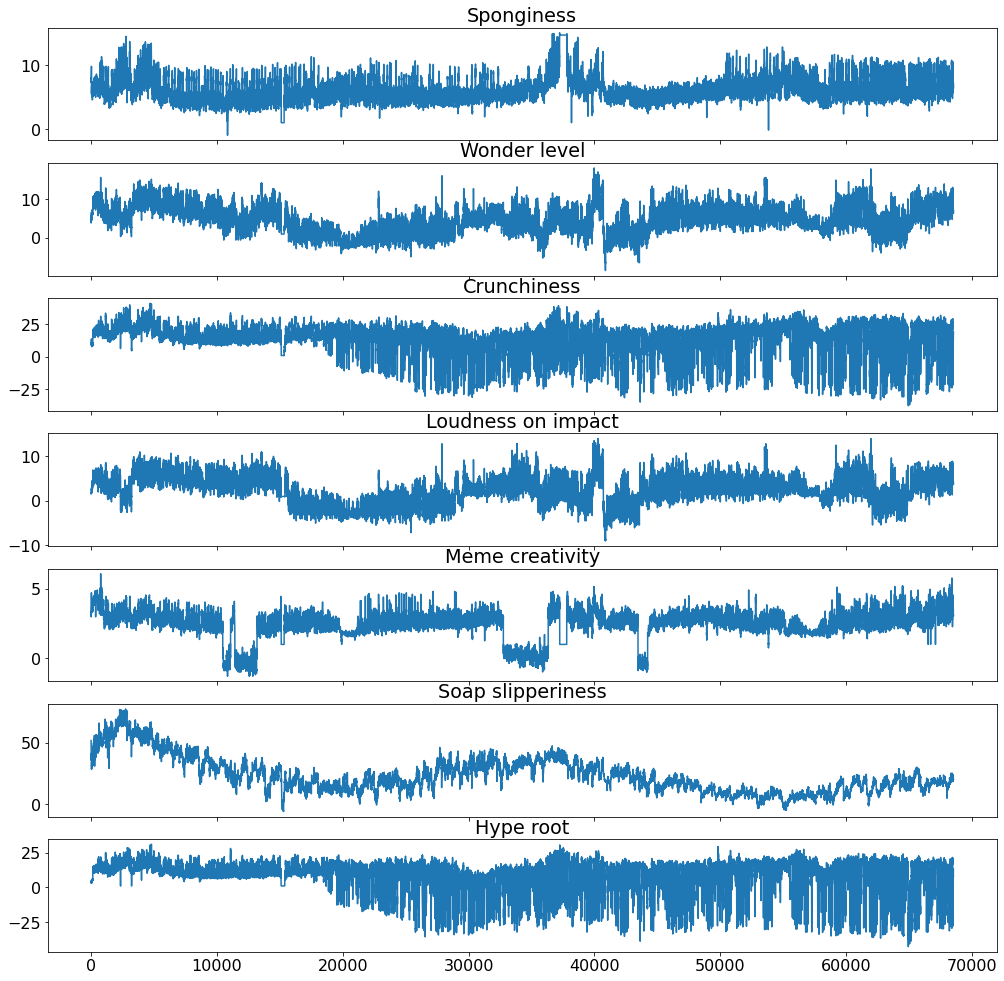

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


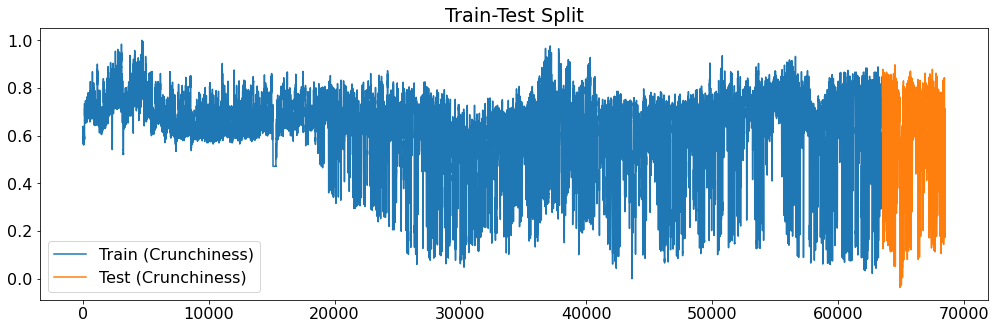

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.MaxPool1D()(lstm)
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(lstm)
    lstm = tfkl.GlobalAveragePooling1D()(lstm)
    lstm = tfkl.Dropout(.5)(lstm)

    # In order to predict the next values for more than one sensor,
    # we can use a Dense layer with a number given by telescope*num_sensors,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_sensors]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(lstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    #output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return model

# Multivariate Forecasting (Autoregression)

In [ ]:
target_labels = dataset.columns
telescope = 1

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12690, 90, 7), (12690, 1, 7), (990, 90, 7), (990, 1, 7))

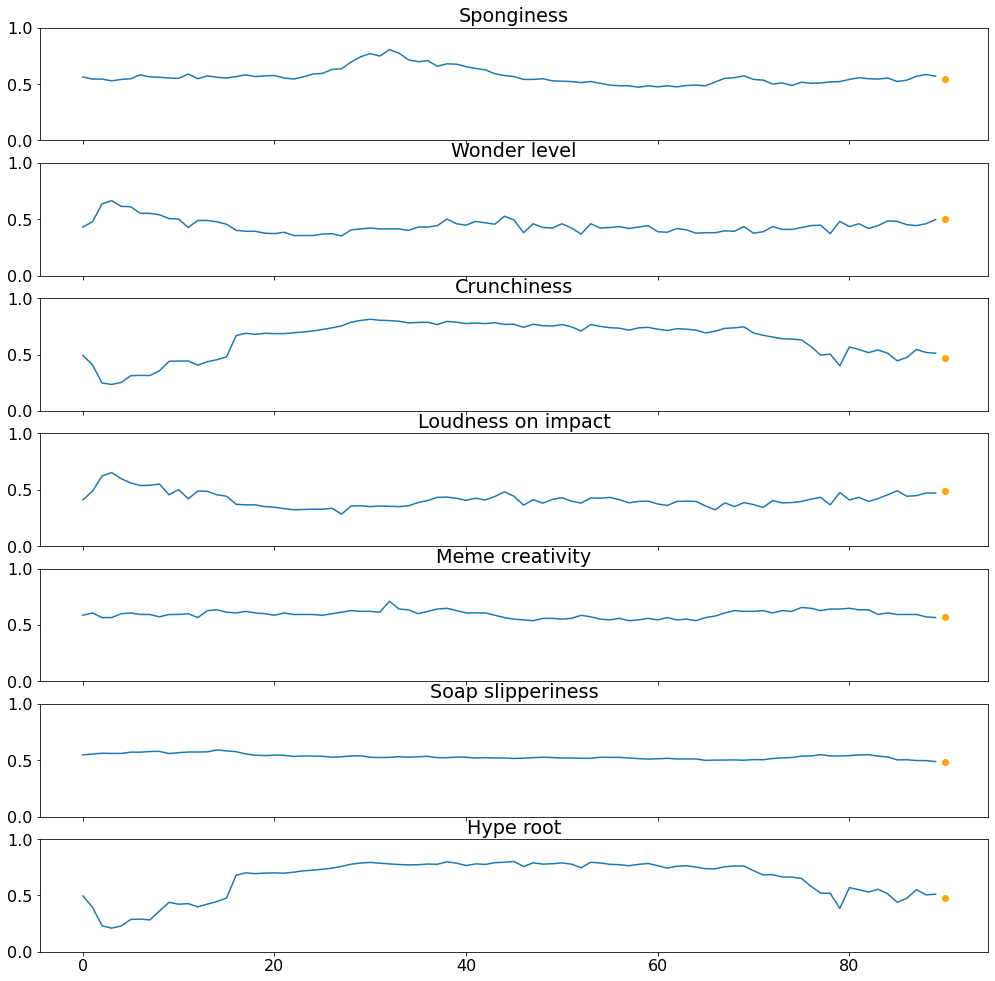

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 500

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 256)          139264    
 l)                                                              
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 256)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 45, 256)          394240    
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                      

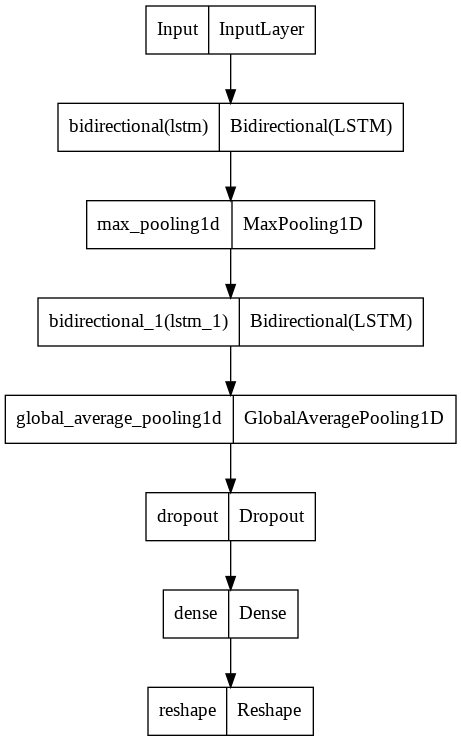

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

#Autoregressive Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
179/179 [==============================] - ETA: 0s - loss: 0.0203 - mae: 0.1048 - rmse: 0.1425

179/179 [==============================] - 46s 197ms/step - loss: 0.0203 - mae: 0.1048 - rmse: 0.1425 - val_loss: 0.0166 - val_mae: 0.0891 - val_rmse: 0.1287 - lr: 0.0010
Epoch 2/500
179/179 [==============================] - ETA: 0s - loss: 0.0124 - mae: 0.0826 - rmse: 0.1111

179/179 [==============================] - 34s 193ms/step - loss: 0.0124 - mae: 0.0826 - rmse: 0.1111 - val_loss: 0.0130 - val_mae: 0.0801 - val_rmse: 0.1141 - lr: 0.0010
Epoch 3/500
179/179 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0705 - rmse: 0.0921

179/179 [==============================] - 35s 196ms/step - loss: 0.0085 - mae: 0.0705 - rmse: 0.0921 - val_loss: 0.0070 - val_mae: 0.0607 - val_rmse: 0.0835 - lr: 0.0010
Epoch 4/500
178/179 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0633 - rmse: 0.0822

179/179 [==============================] - 35s 194ms/step - loss: 0.0068 - mae: 0.0633 - rmse: 0.0822 - val_loss: 0.0065 - val_mae: 0.0600 - val_rmse: 0.0804 - lr: 0.0010
Epoch 5/500
179/179 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0601 - rmse: 0.0779

179/179 [==============================] - 34s 189ms/step - loss: 0.0061 - mae: 0.0601 - rmse: 0.0779 - val_loss: 0.0057 - val_mae: 0.0561 - val_rmse: 0.0757 - lr: 0.0010
Epoch 6/500
178/179 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0571 - rmse: 0.0740

179/179 [==============================] - 34s 191ms/step - loss: 0.0055 - mae: 0.0571 - rmse: 0.0739 - val_loss: 0.0053 - val_mae: 0.0535 - val_rmse: 0.0729 - lr: 0.0010
Epoch 7/500
177/179 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0517 - rmse: 0.0670

179/179 [==============================] - 33s 187ms/step - loss: 0.0045 - mae: 0.0517 - rmse: 0.0670 - val_loss: 0.0032 - val_mae: 0.0412 - val_rmse: 0.0566 - lr: 0.0010
Epoch 8/500
178/179 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0467 - rmse: 0.0606

179/179 [==============================] - 34s 188ms/step - loss: 0.0037 - mae: 0.0467 - rmse: 0.0606 - val_loss: 0.0027 - val_mae: 0.0373 - val_rmse: 0.0519 - lr: 0.0010
Epoch 9/500
178/179 [============================>.] - ETA: 0s - loss: 0.0031 - mae: 0.0429 - rmse: 0.0559

179/179 [==============================] - 33s 186ms/step - loss: 0.0031 - mae: 0.0429 - rmse: 0.0559 - val_loss: 0.0023 - val_mae: 0.0333 - val_rmse: 0.0476 - lr: 0.0010
Epoch 10/500
178/179 [============================>.] - ETA: 0s - loss: 0.0027 - mae: 0.0398 - rmse: 0.0523

179/179 [==============================] - 33s 185ms/step - loss: 0.0027 - mae: 0.0398 - rmse: 0.0522 - val_loss: 0.0030 - val_mae: 0.0413 - val_rmse: 0.0548 - lr: 0.0010
Epoch 11/500
177/179 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0388 - rmse: 0.0511

179/179 [==============================] - 33s 187ms/step - loss: 0.0026 - mae: 0.0388 - rmse: 0.0511 - val_loss: 0.0016 - val_mae: 0.0262 - val_rmse: 0.0395 - lr: 0.0010
Epoch 12/500
179/179 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0366 - rmse: 0.0482

179/179 [==============================] - 33s 186ms/step - loss: 0.0023 - mae: 0.0366 - rmse: 0.0482 - val_loss: 0.0017 - val_mae: 0.0289 - val_rmse: 0.0412 - lr: 0.0010
Epoch 13/500
177/179 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0354 - rmse: 0.0468

179/179 [==============================] - 33s 188ms/step - loss: 0.0022 - mae: 0.0354 - rmse: 0.0468 - val_loss: 0.0018 - val_mae: 0.0302 - val_rmse: 0.0420 - lr: 0.0010
Epoch 14/500
179/179 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0346 - rmse: 0.0458

179/179 [==============================] - 33s 186ms/step - loss: 0.0021 - mae: 0.0346 - rmse: 0.0458 - val_loss: 0.0015 - val_mae: 0.0254 - val_rmse: 0.0386 - lr: 0.0010
Epoch 15/500
178/179 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0335 - rmse: 0.0445

179/179 [==============================] - 33s 183ms/step - loss: 0.0020 - mae: 0.0335 - rmse: 0.0445 - val_loss: 0.0014 - val_mae: 0.0255 - val_rmse: 0.0378 - lr: 0.0010
Epoch 16/500
178/179 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0332 - rmse: 0.0441

179/179 [==============================] - 34s 189ms/step - loss: 0.0019 - mae: 0.0332 - rmse: 0.0441 - val_loss: 0.0015 - val_mae: 0.0261 - val_rmse: 0.0388 - lr: 0.0010
Epoch 17/500
179/179 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0315 - rmse: 0.0420

179/179 [==============================] - 33s 187ms/step - loss: 0.0018 - mae: 0.0315 - rmse: 0.0420 - val_loss: 0.0015 - val_mae: 0.0256 - val_rmse: 0.0384 - lr: 0.0010
Epoch 18/500
177/179 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0307 - rmse: 0.0413

179/179 [==============================] - 34s 189ms/step - loss: 0.0017 - mae: 0.0307 - rmse: 0.0413 - val_loss: 0.0013 - val_mae: 0.0242 - val_rmse: 0.0366 - lr: 0.0010
Epoch 19/500
178/179 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0301 - rmse: 0.0404

179/179 [==============================] - 33s 187ms/step - loss: 0.0016 - mae: 0.0301 - rmse: 0.0404 - val_loss: 0.0013 - val_mae: 0.0230 - val_rmse: 0.0361 - lr: 0.0010
Epoch 20/500
177/179 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0292 - rmse: 0.0395

179/179 [==============================] - 33s 188ms/step - loss: 0.0016 - mae: 0.0291 - rmse: 0.0394 - val_loss: 0.0013 - val_mae: 0.0235 - val_rmse: 0.0362 - lr: 0.0010
Epoch 21/500
178/179 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0285 - rmse: 0.0386

179/179 [==============================] - 33s 187ms/step - loss: 0.0015 - mae: 0.0285 - rmse: 0.0386 - val_loss: 0.0012 - val_mae: 0.0228 - val_rmse: 0.0354 - lr: 0.0010
Epoch 22/500
177/179 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0281 - rmse: 0.0381

179/179 [==============================] - 33s 188ms/step - loss: 0.0015 - mae: 0.0281 - rmse: 0.0381 - val_loss: 0.0014 - val_mae: 0.0250 - val_rmse: 0.0373 - lr: 0.0010
Epoch 23/500
178/179 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0275 - rmse: 0.0376

179/179 [==============================] - 33s 186ms/step - loss: 0.0014 - mae: 0.0275 - rmse: 0.0376 - val_loss: 0.0013 - val_mae: 0.0245 - val_rmse: 0.0367 - lr: 0.0010
Epoch 24/500
179/179 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0274 - rmse: 0.0375

179/179 [==============================] - 34s 189ms/step - loss: 0.0014 - mae: 0.0274 - rmse: 0.0375 - val_loss: 0.0013 - val_mae: 0.0245 - val_rmse: 0.0361 - lr: 0.0010
Epoch 25/500
178/179 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0268 - rmse: 0.0368

179/179 [==============================] - 33s 186ms/step - loss: 0.0014 - mae: 0.0268 - rmse: 0.0368 - val_loss: 0.0013 - val_mae: 0.0233 - val_rmse: 0.0357 - lr: 0.0010
Epoch 26/500
179/179 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0269 - rmse: 0.0367

179/179 [==============================] - 34s 188ms/step - loss: 0.0013 - mae: 0.0269 - rmse: 0.0367 - val_loss: 0.0013 - val_mae: 0.0232 - val_rmse: 0.0354 - lr: 0.0010
Epoch 27/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0254 - rmse: 0.0352

179/179 [==============================] - 34s 189ms/step - loss: 0.0012 - mae: 0.0254 - rmse: 0.0352 - val_loss: 0.0011 - val_mae: 0.0214 - val_rmse: 0.0337 - lr: 5.0000e-04
Epoch 28/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0252 - rmse: 0.0349

179/179 [==============================] - 34s 190ms/step - loss: 0.0012 - mae: 0.0252 - rmse: 0.0349 - val_loss: 0.0012 - val_mae: 0.0214 - val_rmse: 0.0342 - lr: 5.0000e-04
Epoch 29/500
177/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0252 - rmse: 0.0350

179/179 [==============================] - 33s 188ms/step - loss: 0.0012 - mae: 0.0252 - rmse: 0.0349 - val_loss: 0.0011 - val_mae: 0.0210 - val_rmse: 0.0337 - lr: 5.0000e-04
Epoch 30/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0253 - rmse: 0.0350

179/179 [==============================] - 33s 187ms/step - loss: 0.0012 - mae: 0.0253 - rmse: 0.0350 - val_loss: 0.0012 - val_mae: 0.0218 - val_rmse: 0.0343 - lr: 5.0000e-04
Epoch 31/500
177/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0253 - rmse: 0.0352

179/179 [==============================] - 33s 188ms/step - loss: 0.0012 - mae: 0.0253 - rmse: 0.0352 - val_loss: 0.0011 - val_mae: 0.0211 - val_rmse: 0.0339 - lr: 5.0000e-04
Epoch 32/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0251 - rmse: 0.0349

179/179 [==============================] - 34s 188ms/step - loss: 0.0012 - mae: 0.0251 - rmse: 0.0349 - val_loss: 0.0011 - val_mae: 0.0216 - val_rmse: 0.0338 - lr: 5.0000e-04
Epoch 33/500
177/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0244 - rmse: 0.0341

179/179 [==============================] - 33s 186ms/step - loss: 0.0012 - mae: 0.0244 - rmse: 0.0341 - val_loss: 0.0011 - val_mae: 0.0212 - val_rmse: 0.0338 - lr: 2.5000e-04
Epoch 34/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0244 - rmse: 0.0340

179/179 [==============================] - 33s 188ms/step - loss: 0.0012 - mae: 0.0244 - rmse: 0.0341 - val_loss: 0.0012 - val_mae: 0.0215 - val_rmse: 0.0342 - lr: 2.5000e-04
Epoch 35/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0246 - rmse: 0.0344

179/179 [==============================] - 34s 191ms/step - loss: 0.0012 - mae: 0.0246 - rmse: 0.0344 - val_loss: 0.0011 - val_mae: 0.0207 - val_rmse: 0.0334 - lr: 2.5000e-04
Epoch 36/500
177/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0243 - rmse: 0.0340

179/179 [==============================] - 33s 187ms/step - loss: 0.0012 - mae: 0.0243 - rmse: 0.0340 - val_loss: 0.0012 - val_mae: 0.0220 - val_rmse: 0.0344 - lr: 2.5000e-04
Epoch 37/500
177/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0244 - rmse: 0.0341

179/179 [==============================] - 34s 188ms/step - loss: 0.0012 - mae: 0.0244 - rmse: 0.0341 - val_loss: 0.0011 - val_mae: 0.0213 - val_rmse: 0.0339 - lr: 2.5000e-04
Epoch 38/500
177/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0242 - rmse: 0.0340

179/179 [==============================] - 33s 187ms/step - loss: 0.0012 - mae: 0.0242 - rmse: 0.0339 - val_loss: 0.0011 - val_mae: 0.0209 - val_rmse: 0.0334 - lr: 2.5000e-04
Epoch 39/500
179/179 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0243 - rmse: 0.0340

179/179 [==============================] - 33s 187ms/step - loss: 0.0012 - mae: 0.0243 - rmse: 0.0340 - val_loss: 0.0011 - val_mae: 0.0204 - val_rmse: 0.0331 - lr: 2.5000e-04
Epoch 40/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0242 - rmse: 0.0339

179/179 [==============================] - 34s 189ms/step - loss: 0.0012 - mae: 0.0242 - rmse: 0.0339 - val_loss: 0.0011 - val_mae: 0.0205 - val_rmse: 0.0332 - lr: 2.5000e-04
Epoch 41/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0242 - rmse: 0.0339

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0242 - rmse: 0.0339 - val_loss: 0.0011 - val_mae: 0.0204 - val_rmse: 0.0331 - lr: 2.5000e-04
Epoch 42/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0242 - rmse: 0.0339

179/179 [==============================] - 34s 189ms/step - loss: 0.0012 - mae: 0.0242 - rmse: 0.0339 - val_loss: 0.0011 - val_mae: 0.0207 - val_rmse: 0.0332 - lr: 2.5000e-04
Epoch 43/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0241 - rmse: 0.0338

179/179 [==============================] - 35s 195ms/step - loss: 0.0011 - mae: 0.0241 - rmse: 0.0338 - val_loss: 0.0011 - val_mae: 0.0213 - val_rmse: 0.0337 - lr: 2.5000e-04
Epoch 44/500
178/179 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0244 - rmse: 0.0340

179/179 [==============================] - 34s 191ms/step - loss: 0.0012 - mae: 0.0244 - rmse: 0.0340 - val_loss: 0.0011 - val_mae: 0.0206 - val_rmse: 0.0332 - lr: 2.5000e-04
Epoch 45/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336 - val_loss: 0.0011 - val_mae: 0.0204 - val_rmse: 0.0331 - lr: 1.2500e-04
Epoch 46/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0239 - rmse: 0.0336

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0239 - rmse: 0.0336 - val_loss: 0.0011 - val_mae: 0.0211 - val_rmse: 0.0335 - lr: 1.2500e-04
Epoch 47/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336 - val_loss: 0.0011 - val_mae: 0.0205 - val_rmse: 0.0330 - lr: 1.2500e-04
Epoch 48/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335 - val_loss: 0.0011 - val_mae: 0.0203 - val_rmse: 0.0329 - lr: 1.2500e-04
Epoch 49/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0239 - rmse: 0.0334

179/179 [==============================] - 35s 194ms/step - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335 - val_loss: 0.0011 - val_mae: 0.0209 - val_rmse: 0.0331 - lr: 1.2500e-04
Epoch 50/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335 - val_loss: 0.0011 - val_mae: 0.0208 - val_rmse: 0.0334 - lr: 1.2500e-04
Epoch 51/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0238 - rmse: 0.0334

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0238 - rmse: 0.0334 - val_loss: 0.0011 - val_mae: 0.0203 - val_rmse: 0.0330 - lr: 1.2500e-04
Epoch 52/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335 - val_loss: 0.0012 - val_mae: 0.0227 - val_rmse: 0.0351 - lr: 1.2500e-04
Epoch 53/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0328 - lr: 1.2500e-04
Epoch 54/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0240 - rmse: 0.0337

179/179 [==============================] - 34s 188ms/step - loss: 0.0011 - mae: 0.0240 - rmse: 0.0336 - val_loss: 0.0011 - val_mae: 0.0208 - val_rmse: 0.0332 - lr: 1.2500e-04
Epoch 55/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0241 - rmse: 0.0337

179/179 [==============================] - 33s 188ms/step - loss: 0.0011 - mae: 0.0241 - rmse: 0.0337 - val_loss: 0.0011 - val_mae: 0.0206 - val_rmse: 0.0334 - lr: 1.2500e-04
Epoch 56/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0239 - rmse: 0.0335 - val_loss: 0.0011 - val_mae: 0.0203 - val_rmse: 0.0331 - lr: 1.2500e-04
Epoch 57/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0237 - rmse: 0.0333

179/179 [==============================] - 34s 191ms/step - loss: 0.0011 - mae: 0.0237 - rmse: 0.0333 - val_loss: 0.0011 - val_mae: 0.0210 - val_rmse: 0.0332 - lr: 1.2500e-04
Epoch 58/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0238 - rmse: 0.0334

179/179 [==============================] - 33s 188ms/step - loss: 0.0011 - mae: 0.0238 - rmse: 0.0334 - val_loss: 0.0011 - val_mae: 0.0212 - val_rmse: 0.0334 - lr: 1.2500e-04
Epoch 59/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0237 - rmse: 0.0334

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0237 - rmse: 0.0334 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 6.2500e-05
Epoch 60/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0236 - rmse: 0.0333

179/179 [==============================] - 33s 188ms/step - loss: 0.0011 - mae: 0.0236 - rmse: 0.0333 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 6.2500e-05
Epoch 61/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0236 - rmse: 0.0331

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0236 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0327 - lr: 6.2500e-05
Epoch 62/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0236 - rmse: 0.0332

179/179 [==============================] - 34s 191ms/step - loss: 0.0011 - mae: 0.0236 - rmse: 0.0332 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0326 - lr: 6.2500e-05
Epoch 63/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0237 - rmse: 0.0333

179/179 [==============================] - 34s 191ms/step - loss: 0.0011 - mae: 0.0237 - rmse: 0.0332 - val_loss: 0.0011 - val_mae: 0.0201 - val_rmse: 0.0328 - lr: 6.2500e-05
Epoch 64/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0238 - rmse: 0.0334

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0238 - rmse: 0.0334 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0329 - lr: 6.2500e-05
Epoch 65/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0325 - lr: 3.1250e-05
Epoch 66/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0236 - rmse: 0.0331

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0236 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0202 - val_rmse: 0.0328 - lr: 3.1250e-05
Epoch 67/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0237 - rmse: 0.0333

179/179 [==============================] - 34s 193ms/step - loss: 0.0011 - mae: 0.0237 - rmse: 0.0332 - val_loss: 0.0011 - val_mae: 0.0205 - val_rmse: 0.0330 - lr: 3.1250e-05
Epoch 68/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0204 - val_rmse: 0.0330 - lr: 3.1250e-05
Epoch 69/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 3.1250e-05
Epoch 70/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 34s 191ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.5625e-05
Epoch 71/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 35s 194ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0197 - val_rmse: 0.0326 - lr: 1.5625e-05
Epoch 72/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0327 - lr: 1.5625e-05
Epoch 73/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 34s 191ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.5625e-05
Epoch 74/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0236 - rmse: 0.0332

179/179 [==============================] - 34s 191ms/step - loss: 0.0011 - mae: 0.0236 - rmse: 0.0332 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0327 - lr: 1.5625e-05
Epoch 75/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 76/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 77/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 78/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 33s 188ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 79/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 80/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330

179/179 [==============================] - 34s 188ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 81/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 82/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 83/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0233 - rmse: 0.0328

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0200 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 84/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 33s 188ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 85/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 33s 186ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 86/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0332

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 87/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 88/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 33s 187ms/step - loss: 0.0011 - mae: 0.0233 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 89/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 33s 188ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 90/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330

179/179 [==============================] - 34s 189ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0198 - val_rmse: 0.0326 - lr: 1.0000e-05
Epoch 91/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 92/500
179/179 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 93/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 34s 190ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 1.0000e-05
Epoch 94/500
177/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0235 - rmse: 0.0331

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0235 - rmse: 0.0330 - val_loss: 0.0011 - val_mae: 0.0203 - val_rmse: 0.0329 - lr: 1.0000e-05
Epoch 95/500
178/179 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329

179/179 [==============================] - 34s 192ms/step - loss: 0.0011 - mae: 0.0234 - rmse: 0.0329 - val_loss: 0.0011 - val_mae: 0.0199 - val_rmse: 0.0327 - lr: 1.0000e-05


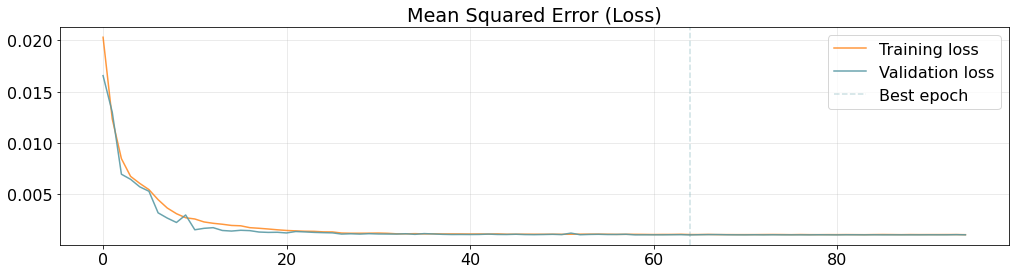

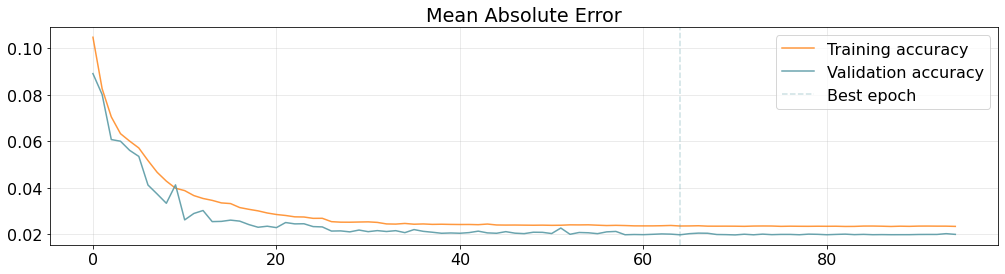

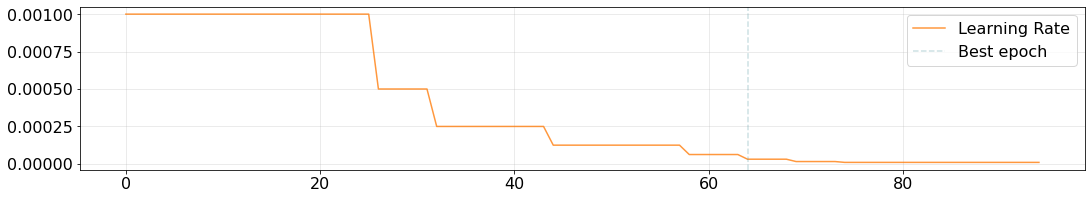

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Models/'+title+'_AutoregressiveForecasting')
#model = tfk.models.load_model('Models/'+title+'_AutoregressiveForecasting')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(990, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.001275305>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.022395596>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

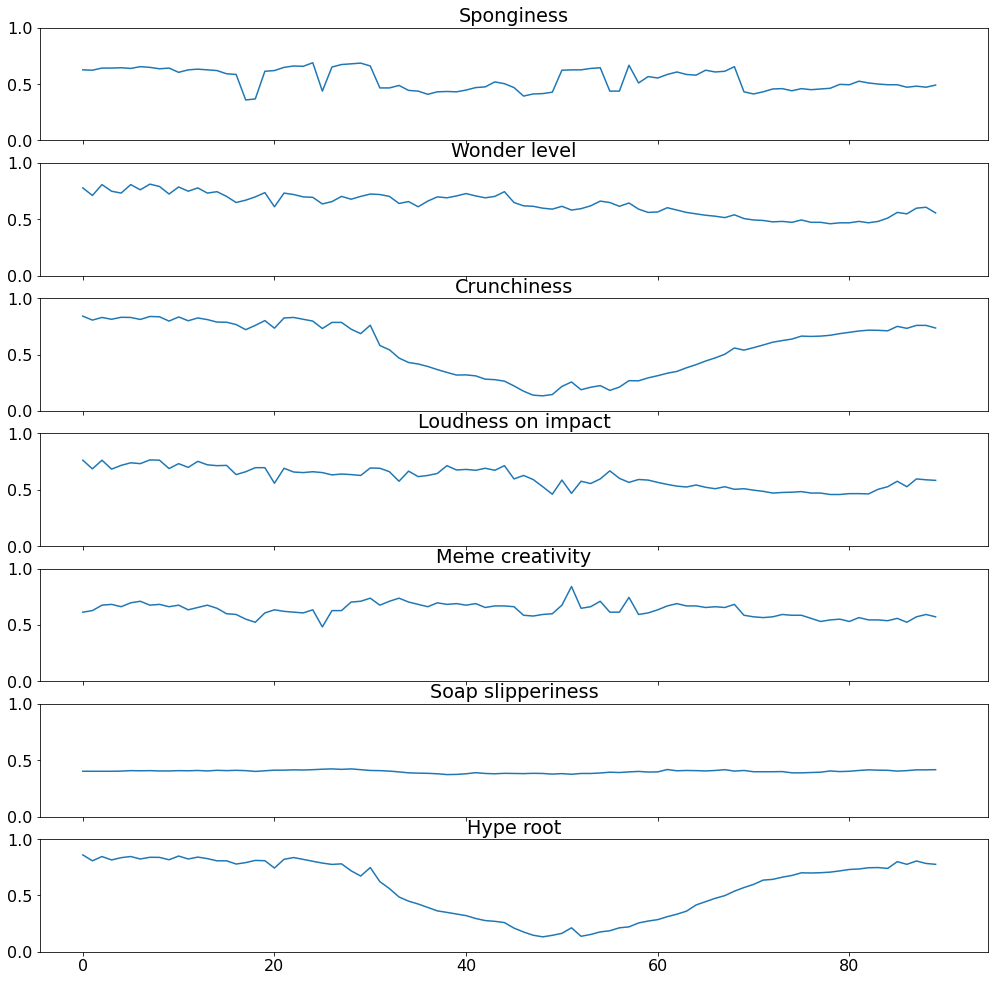

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
reg_telescope = general_telescope
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((818, 90, 7), (818, 864, 7))

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(818, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.015405706>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09409138>)

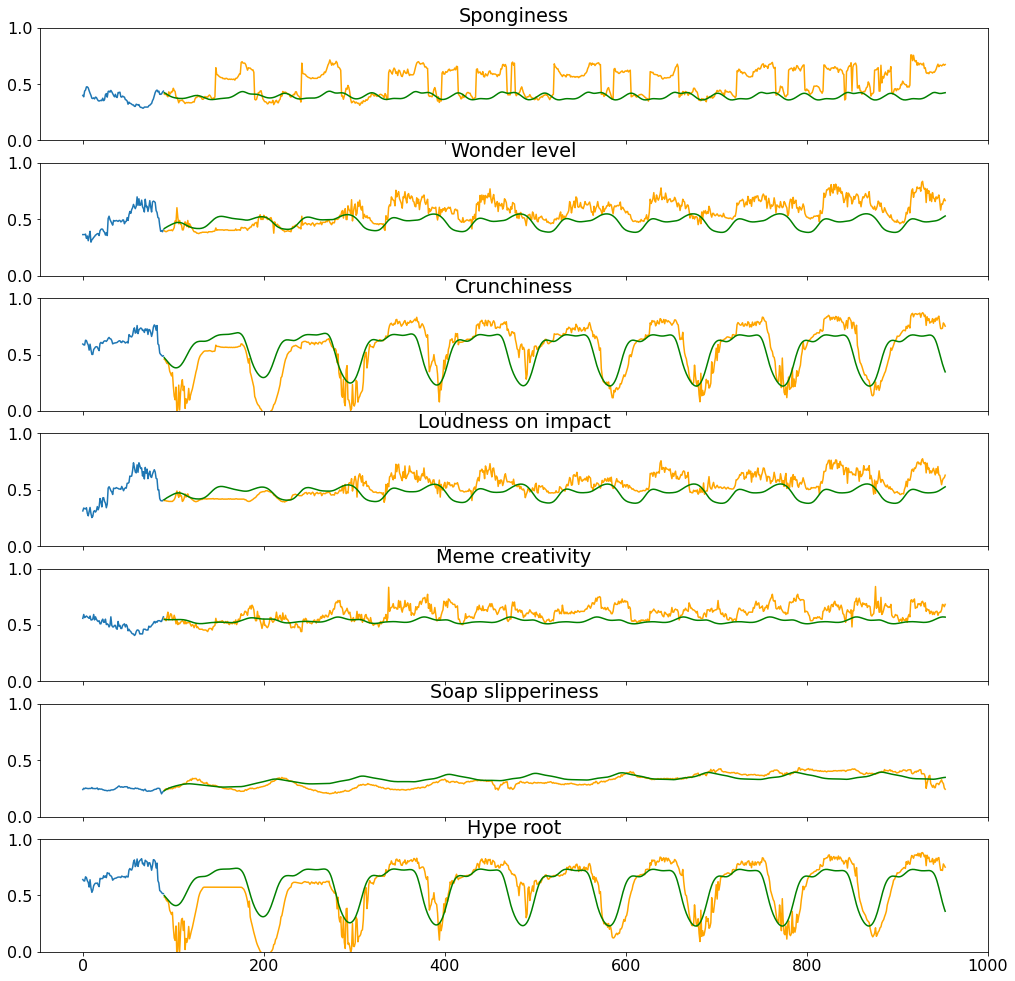

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

#Predicting the future with Autoregressive Model

In [ ]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
reg_future = np.array([])
X_temp = future
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

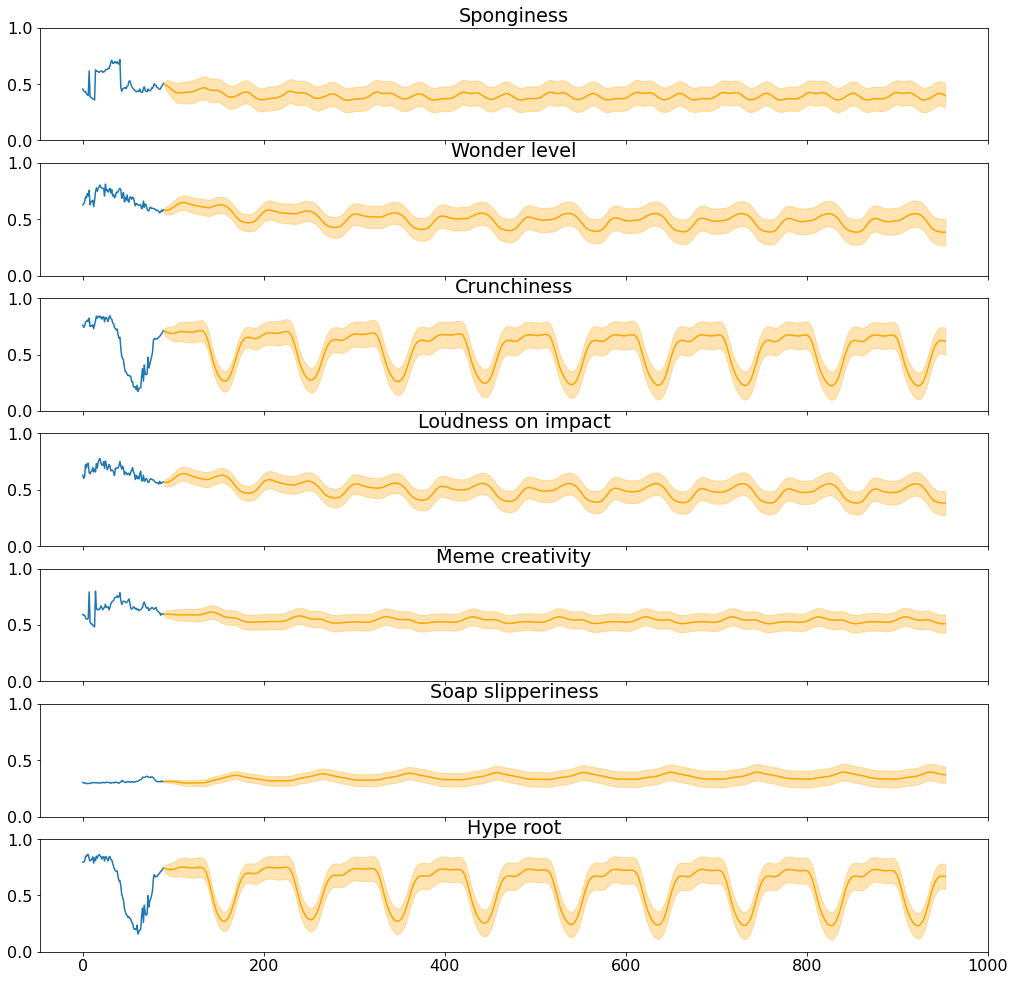

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()